# Getting familiar with `causalgraphicalmodels` library.

We'll use this library for data generation and analysis

Installation

In [95]:
!pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

## Exercise 1.1

Confirm that sampled data from `fd0` and `fd1` indeed follows the defined structure

### Discrete models

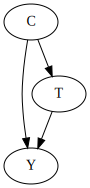

In [97]:
fd0 = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "T": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.7,0.3)}),   
    "Y": discrete_model(["T", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
    }),
})

fd0.cgm.draw()

**[HMD]**

When $C = 1 ⇒ T = 0$ with prob. 0.7 and $T=1$ with prob. 0.3.

When $C=0 \Rightarrow T=1$ with prob. 0.1 and $T =1$ wit prob 0.9

Number of entries: choice of values

T is the treatment
Y is the outcome
C is the confounded 

**[HMD-T]**

Let us generate a sample from model `fd0`

In [98]:
# generating sample from the data of the required size
data_df_0 = fd0.sample(n_samples=100000)
print(len(data_df_0))
data_df_0.head()

100000


,C,T,Y
0,1,0.0,0.0
1,1,0.0,0.0
2,0,1.0,0.0
3,1,0.0,1.0
4,0,1.0,0.0


**[HMD]: Some basic queries**

In [99]:
Y_query = data_df_0.query('T == 0 and C == 0')['Y']
print(f"Count of Y = 1 when T = 0 & C = 0: {np.count_nonzero(Y_query == 1)}")
print(f"Count of Y = 0 when T = 0 & C = 0: {np.count_nonzero(Y_query == 0)}")


Count of Y = 1 when T = 0 & C = 0: 4498
Count of Y = 0 when T = 0 & C = 0: 502


As expected, since $\mathbb{P}(Y = 1 | T = 0 \& C = 0) = 0.9$, most observations of $Y$ have 1 value.

### 1.1.1

We expect the following data generation process:
1. `"C": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples)`: $C$ is an idependent random variable distributed according to [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Binomial distribution has 2 possible values, so $C$ is a [binary variable](https://en.wikipedia.org/wiki/Binary_data). `p=0.5` means that probability to get $C=1$ is 0.5 and, thus, the probability to get $C=0$ is also 0.5. Let us confirm that $C$ is distributed accordingly. We can do so by plotting a histogram.

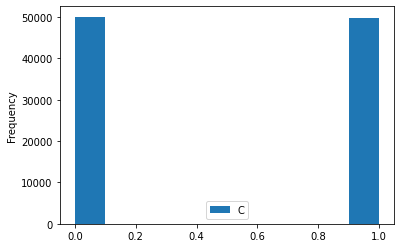

In [100]:
data_df_0[['C']].plot(
    kind='hist',
)

As expected, $C$ takes only 2 possible values 0 and 1 and the probability to get these values is approximately the same.

### 1.1.2

2. `"T": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.7,0.3)})`: $T$ is a discrete variable that depends on $C$. If $C=0$, then $T$ can have 2 possible values (the number of possible values is defined by the number of elements in the tuple `(0.1,0.9)`) encoded as 0 and 1. In this library, for discrete variables we start with 0. The probability of getting $T=0$ when $C=0$ is $P(T=0|C=0) = 0.1$ and the probability of getting $T=1$ when $C=0$ is $P(T=1|C=0) = 0.9$. Similarly, $P(T=0|C=1) = 0.7$ and $P(T=1|C=1) = 0.3$. Let us confirm that the generated data follows the descirbed distribution.

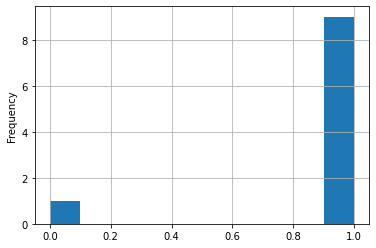

In [101]:
df_tmp = data_df_0[data_df_0['C'] == 0] # take the part of the dataset for which C=0
df_tmp['T'].plot(
    kind='hist',
    density=True,
    grid=True,
)

Exc: Do it 

Indeed, in $\sim 10\%$ of the cases we observe $T=0$. In the rest of the case we observe $T=1$.

Confirm that distribution is correct for $C=1$

Your solution:

**[HMD-Solution]**

We impose the condition $C=1$ on the dataframe, and plot histogram of its values (0,1)

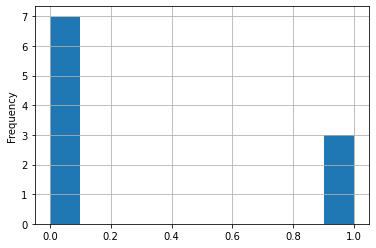

In [102]:
df_tmp = data_df_0[data_df_0['C'] == 1] # take the part of the dataset for which C=0
df_tmp['T'].plot(
    kind='hist',
    density=True,
    grid=True,
)

As shown, the histogram verifies the distribution of T when $C=1$, meaning that $P(T=0|C=1) = 0.7$ and $P(T=1|C=1) = 0.3$

In [103]:
print(np.count_nonzero(df_tmp['T'] == 1) / df_tmp.shape[0])
print(np.count_nonzero(df_tmp['T'] == 0) / df_tmp.shape[0])

0.30106406428471233
0.6989359357152877


### 1.1.3

3. Finally, for variable $Y$ we have:
```python
"Y": discrete_model(["T", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
    }),
```
Again, $Y$ is a discrete variable that depends on $T$ and $C$. As both $T$ and $C$ are binomial, there are only 4 possible input combinations presented in the code above. For every possible input, we specify how the values of $Y$ are distributed. As the number of elements in the tuples like `(0.1, 0.9)` is always 2, we can conclude that $Y$ is also a binary variable.

Confirm that $Y$ is distributed accoding to the specified distribution.

Your solution:

**[HMD-Solution]**

We draw histogram for the values of Y given all 4 possible combination of values for (C,T).
We also count the values in the dataframes.


#### Case I. $T=0,C=0$

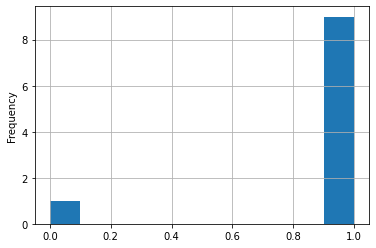

In [104]:
df_tmp = data_df_0.query('T == 0 and C == 0')
df_tmp['Y'].plot(
    kind='hist',
    density=True,
    grid=True,
)

In [105]:
print(np.count_nonzero(df_tmp['Y'] == 1) / df_tmp.shape[0])
print(np.count_nonzero(df_tmp['Y'] == 0) / df_tmp.shape[0])

0.8996
0.1004


#### Case II. $T = 0, C =1$

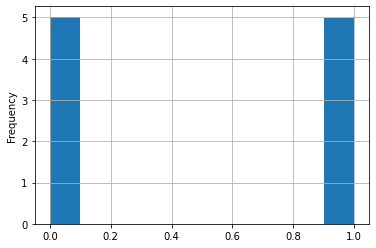

In [106]:
df_tmp = data_df_0.query('T == 0 and C == 1')
df_tmp['Y'].plot(
    kind='hist',
    density=True,
    grid=True,
)

In [107]:
print(np.count_nonzero(df_tmp['Y'] == 1) / df_tmp.shape[0])
print(np.count_nonzero(df_tmp['Y'] == 0) / df_tmp.shape[0])

0.49838011410877603
0.501619885891224


#### Case III. $T = 1, C =0$

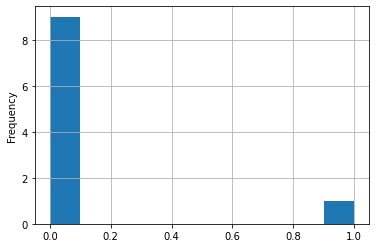

In [108]:
df_tmp = data_df_0.query('T == 1 and C == 0')
df_tmp['Y'].plot(
    kind='hist',
    density=True,
    grid=True,
)

In [109]:
print(np.count_nonzero(df_tmp['Y'] == 1) / df_tmp.shape[0])
print(np.count_nonzero(df_tmp['Y'] == 0) / df_tmp.shape[0])

0.09989578020710912
0.9001042197928909


#### Case IV. $T = 1, C =1$

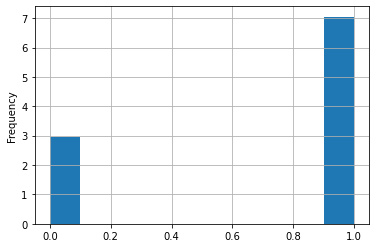

In [110]:
df_tmp = data_df_0.query('T == 1 and C == 1')
df_tmp['Y'].plot(
    kind='hist',
    density=True,
    grid=True,
)

In [111]:
print(np.count_nonzero(df_tmp['Y'] == 1) / df_tmp.shape[0])
print(np.count_nonzero(df_tmp['Y'] == 0) / df_tmp.shape[0])

0.7048056443024494
0.2951943556975506


**[HMD-T]**

### Continuous models

For an example of a continuous model we will consider the model `fd1`:

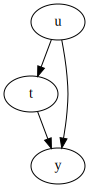

In [112]:
fd1 = StructuralCausalModel({
    "u": lambda n_samples: np.random.normal(0, 1, size=n_samples),
    "t": lambda u, n_samples: 2 * u,             # T is a linear function of U
    "y": lambda u, t, n_samples: 3 * t + 2 * u,  # Y is a linear function of u and t
})

fd1.cgm.draw()

This case is continuous. We can have combinations.
For instance output a conidtional function on a continous input variable


Let us generate a sample

In [113]:
# generating sample from the data of the required size
data_df_1 = fd1.sample(n_samples=100000)
print(len(data_df_1))
data_df_1.head()

100000


,u,t,y
0,1.102267,2.204534,8.818135
1,-0.129082,-0.258164,-1.032654
2,-1.117200,-2.234401,-8.937602
3,-0.255764,-0.511529,-2.046115
4,-1.535242,-3.070484,-12.281935


Confirm that the variables are distributed as expected. As this is a deterministic system, to do such an analysis for variable $T$, for example, you can calculate the expected value of $T$ using the formula $T := 2 U$ and sampled values of $U$, and confirm that the values from the sample correspond to the calculated values. Thas is you will need to evaluate the following equality:
`data_df_1['t'] == 2 * data_df_1['u']`

Useful links: [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution).

In [114]:
query = data_df_1['t'] ==  2 * data_df_1['u']

In [115]:
query

0        True
1        True
2        True
3        True
4        True
         ... 
99995    True
99996    True
99997    True
99998    True
99999    True
Length: 100000, dtype: bool

In [116]:
print(len(query))

100000


In [117]:
np.count_nonzero(query)

100000

## Exercise 1.2

1. If you are not familiar with `np.random.binomial`, `np.random.normal`, `np.random.uniform`, study the related documentation and understand how these function work and what are the input parameters.

1. Change `fd0` such that $P(C = 0 ) = 0.2$. Sample from the resulting model and confirm that the data is distributed as expected.

1. Change `fd0` such that variable $T$ would have 3 possible values. Assign probabilities of each value as you like. Adjust calcuation of $Y$ as now more incoming combinations of $T$ and $C$ are possible (not 4, but 6). Generate a sample and confirm the distributions follow the defined model.

2. Change `fd1` such that $U$ would be distribute according to uniform distribution. Hint: use `np.random.uniform`. Generate a sample and confirm the distributions follow the defined model.

Your solution

**[HMD-Solution]**

### 1.2.2

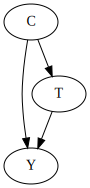

In [118]:
fd02 = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.8, size=n_samples),
    "T": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.7,0.3)}),   
    "Y": discrete_model(["T", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
    }),
})

fd02.cgm.draw()

In [119]:
# generating sample from the data of the required size
df_fd02 = fd02.sample(n_samples=100000)
print(len(df_fd02))
df_fd02.head(20)

100000


,C,T,Y
0,1,0.0,0.0
1,1,1.0,1.0
2,1,1.0,1.0
3,1,0.0,1.0
4,1,0.0,0.0
5,1,0.0,0.0
6,0,1.0,0.0
7,1,0.0,1.0
8,1,0.0,1.0
9,1,1.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


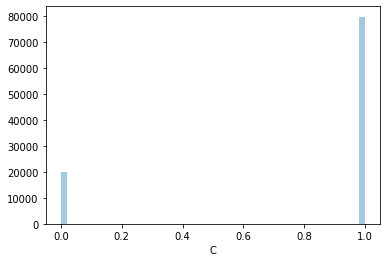

In [120]:
## draw plot of binomial
## confirming distribution of C


sns.distplot(df_fd02['C'], hist=True, kde=False)

As shown in the plot, in our sample $\mathbb{P} (C = 1) \approx 0.8$ and $\mathbb{P} (C = 0) \approx 0.2$

In [121]:
print(np.count_nonzero(df_fd02['C'] == 1) / df_fd02.shape[0])
print(np.count_nonzero(df_fd02['C'] == 0) / df_fd02.shape[0])

0.79877
0.20123


### 1.2.3

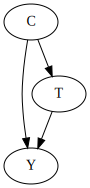

In [122]:
fd03 = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.8, size=n_samples),
    "T": discrete_model(["C"], {(0,): (0.2, 0.3, 0.5), (1,): (0.3, 0.3, 0.4)}),   
    "Y": discrete_model(["T", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
        (2, 0): (0.7, 0.3),
        (2, 1): (0.5, 0.5),
    }),
})

fd03.cgm.draw()

In [123]:
# generating sample from the data of the required size
df_fd03 = fd03.sample(n_samples=100000)
print(len(df_fd03))
df_fd03.head(20)

100000


,C,T,Y
0,0,0.0,1.0
1,1,1.0,1.0
2,0,1.0,0.0
3,1,1.0,1.0
4,1,2.0,1.0
5,1,2.0,1.0
6,1,1.0,1.0
7,1,2.0,1.0
8,0,1.0,0.0
9,1,0.0,1.0


In [124]:
df_fd03[df_fd03['T'] == 2]

,C,T,Y
4,1,2.0,1.0
5,1,2.0,1.0
7,1,2.0,1.0
10,1,2.0,0.0
11,1,2.0,0.0
...,...,...,...
99985,1,2.0,1.0
99986,0,2.0,1.0
99994,1,2.0,0.0
99996,1,2.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


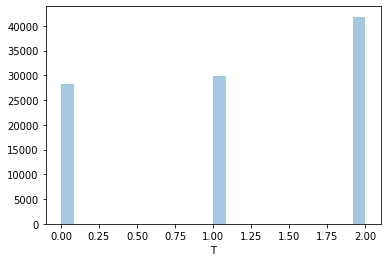

In [125]:
## draw plot of binomial
## confirming distribution of T

sns.distplot(df_fd03['T'], hist=True, kde=False)

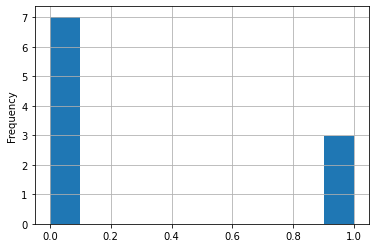

In [126]:
Y_query = df_fd03.query('T == 2 and C == 0')['Y']
Y_query.plot(
    kind='hist',
    density=True,
    grid=True,
)

In [127]:
print(np.count_nonzero(Y_query == 1) / len(Y_query))
print(np.count_nonzero(Y_query == 0) / len(Y_query))

0.29845814977973567
0.7015418502202643


As shown,
$\mathbb{P} (Y = 1| T=2, C=0) \approx 0.3$ and $\mathbb{P} (Y = 0| T=2, C=0) \approx 0.3$

### 1.2.4

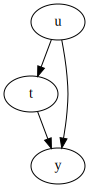

In [132]:
fd12 = StructuralCausalModel({
    "u": lambda n_samples: np.random.uniform(0, 1, size=n_samples),
    "t": lambda u, n_samples: 2 * u,             # T is a linear function of U
    "y": lambda u, t, n_samples: 3 * t + 2 * u,  # Y is a linear function of u and t
})

fd12.cgm.draw()

In [133]:
# generating sample from the data of the required size
data_df_12 = fd12.sample(n_samples=100000)
print(len(data_df_12))
data_df_12.head()

100000


,u,t,y
0,0.672707,1.345415,5.381659
1,0.196005,0.392010,1.568041
2,0.918780,1.837559,7.350237
3,0.001272,0.002544,0.010177
4,0.638561,1.277123,5.108491


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


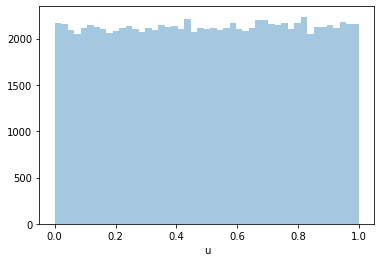

In [135]:
## draw plot of binomial
## confirming distribution of U

sns.distplot(data_df_12['u'], hist=True, kde=False)

As shown in the histogram, the distribution of u is approximately uniform

**[HMD-T]**